In [14]:
# First code block - Data preparation and saving
import numpy as np
import rasterio
import pandas as pd
import os
from matplotlib import pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
%matplotlib inline

def normalize_band(band, min_val=None, max_val=None):
    """Normalize the input band to the range 0-255."""
    if min_val is None:
        min_val = band.min()
    if max_val is None:
        max_val = band.max()
    if max_val == min_val:
        return np.zeros_like(band)
    normalized_band = ((band - min_val) / (max_val - min_val)) * 255
    return normalized_band.astype(np.uint8)

def analyze_masks_and_tiffs(masks_dir, tiffs_dir, band1_idx, band2_idx, 
                          class_labels, band_names, points_per_image=10000):
    """Analyze mask and TIF file pairs and return data for visualization."""
    combined_data = {'class': [], 'band1': [], 'band2': [], 'image': []}
    
    for mask_filename in os.listdir(masks_dir):
        if not mask_filename.endswith("_Visual_mask.png"):
            continue
            
        mask_path = os.path.join(masks_dir, mask_filename)
        tif_filename = mask_filename.replace("_Visual_mask.png", "_AnalyticMS_SR.tif")
        tif_path = os.path.join(tiffs_dir, tif_filename)
        
        if not os.path.exists(tif_path):
            print(f"TIF file not found for mask: {mask_filename}")
            continue
        
        print(f"Processing {mask_filename}...")
        
        with rasterio.open(mask_path) as mask_src:
            mask = mask_src.read(1)
        
        with rasterio.open(tif_path) as tif_src:
            band1 = normalize_band(tif_src.read(band1_idx))
            band2 = normalize_band(tif_src.read(band2_idx))
        
        for class_id, class_name in class_labels.items():
            class_mask = (mask == class_id)
            if not np.any(class_mask):
                continue
                
            b1_values = band1[class_mask]
            b2_values = band2[class_mask]
            
            if len(b1_values) > points_per_image:
                indices = np.random.choice(len(b1_values), points_per_image, replace=False)
                b1_values = b1_values[indices]
                b2_values = b2_values[indices]
            
            combined_data['class'].extend([class_name] * len(b1_values))
            combined_data['band1'].extend(b1_values.tolist())
            combined_data['band2'].extend(b2_values.tolist())
            combined_data['image'].extend([mask_filename] * len(b1_values))
    
    df = pd.DataFrame(combined_data)
    # Save the DataFrame
    df.to_csv('scatter_plot_data.csv', index=False)
    return df

# Run this block first to prepare and save the data
df = analyze_masks_and_tiffs(
    masks_dir=masks_dir,
    tiffs_dir=tiffs_dir,
    band1_idx=band1_idx,
    band2_idx=band2_idx,
    class_labels=class_labels,
    band_names=band_names,
    points_per_image=2000
)

Processing 20230511_212249_22_24bb_3B_Visual_mask.png...


c:\Users\noahj\anaconda3\Lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processing 20230511_214253_20_2251_3B_Visual_mask.png...
Processing 20230521_214254_60_2251_3B_Visual_mask.png...


In [15]:
# Second code block - Plot class definition
class InteractivePlot:
    def __init__(self, band_names, class_colors, band1_idx, band2_idx):
        self.band_names = band_names
        self.class_colors = class_colors
        self.band1_idx = band1_idx
        self.band2_idx = band2_idx
        self.df = pd.read_csv('scatter_plot_data.csv')
        
        # Initialize the class visibility dictionary
        self.class_visibility = {class_name: True for class_name in self.df['class'].unique()}
        
        # Create widgets
        self.setup_widgets()
    
    def setup_widgets(self):
        """Create interactive widgets for class toggling."""
        classes = sorted(self.df['class'].unique())
        
        # Create checkboxes
        checkbox_list = []
        self.class_toggles = {}
        
        for class_name in classes:
            checkbox = widgets.Checkbox(
                value=True,
                description=class_name,
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='150px')
            )
            self.class_toggles[class_name] = checkbox
            checkbox_list.append(checkbox)
        
        # Create buttons
        self.select_all = widgets.Button(
            description='Select All',
            layout=widgets.Layout(width='100px')
        )
        self.select_none = widgets.Button(
            description='Select None',
            layout=widgets.Layout(width='100px')
        )
        self.draw_button = widgets.Button(
            description='Draw Chart',
            layout=widgets.Layout(width='100px')
        )
        
        self.select_all.on_click(self.select_all_clicked)
        self.select_none.on_click(self.select_none_clicked)
        self.draw_button.on_click(self.draw_plot)
        
        # Arrange widgets
        checkbox_container = widgets.HBox(checkbox_list)
        button_container = widgets.HBox([self.select_all, self.select_none, self.draw_button])
        
        # Display widgets
        display(widgets.VBox([checkbox_container, button_container]))
    
    def draw_plot(self, _):
        """Draw the plot based on current visibility settings."""
        # Update visibility dictionary
        for class_name, checkbox in self.class_toggles.items():
            self.class_visibility[class_name] = checkbox.value
        
        # Clear previous output and create new figure
        clear_output(wait=True)
        self.setup_widgets()  # Redisplay widgets
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Filter data based on visible classes
        visible_classes = [class_name for class_name, visible in self.class_visibility.items() if visible]
        visible_data = self.df[self.df['class'].isin(visible_classes)]
        
        # Plot each visible class
        for class_name in visible_classes:
            mask = visible_data['class'] == class_name
            ax.scatter(
                visible_data[mask]['band1'],
                visible_data[mask]['band2'],
                c=self.class_colors[class_name],
                label=class_name,
                alpha=0.6,
                s=20
            )
        
        # Update layout
        ax.set_xlabel(f'Band {self.band1_idx} ({self.band_names[self.band1_idx]}, 0-255)')
        ax.set_ylabel(f'Band {self.band2_idx} ({self.band_names[self.band2_idx]}, 0-255)')
        ax.set_title(f'{self.band_names[self.band1_idx]} vs {self.band_names[self.band2_idx]} Values Distribution by Class')
        ax.set_xlim(0, 255)
        ax.set_ylim(0, 255)
        if visible_classes:  # Only show legend if there are visible classes
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def select_all_clicked(self, _):
        """Select all classes."""
        for checkbox in self.class_toggles.values():
            checkbox.value = True
    
    def select_none_clicked(self, _):
        """Deselect all classes."""
        for checkbox in self.class_toggles.values():
            checkbox.value = False

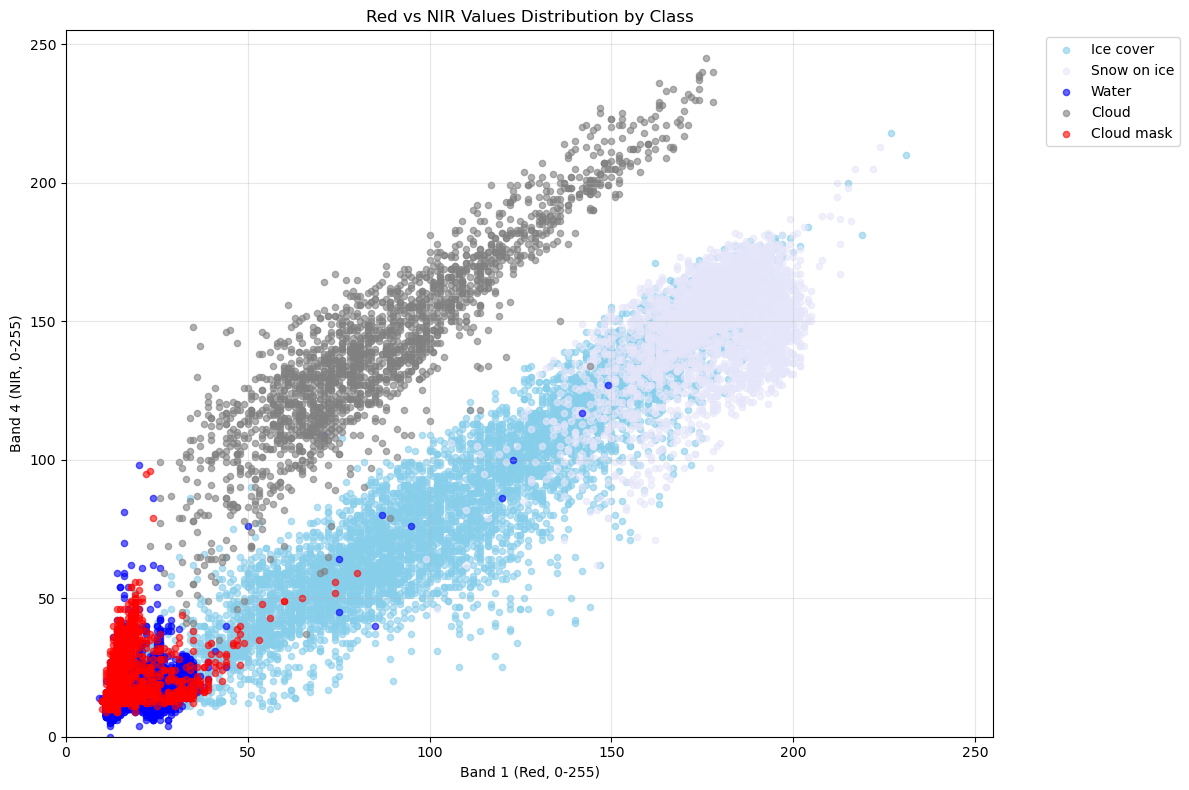

In [16]:
# Third code block - Create and display the interactive plot
plot = InteractivePlot(band_names, class_colors, band1_idx, band2_idx)